# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this projet, I will use _color selection_, _region of interest selection_, _grayscaling_, _Gaussian smoothing_, _Canny Edge Detection_ and _Hough Tranform line detection_ to detect the lane line from the figures of the road. 

### Load packages

In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
import moviepy
import math
%matplotlib inline

### Read the image list

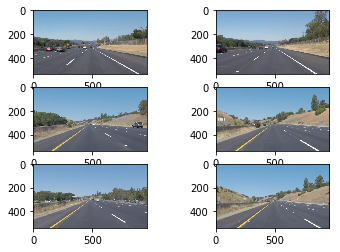

In [2]:
#define the function for image list reading
def img_read(image_dir):
    image_files=[f for f in os.listdir(image_dir) if f[-3:] == 'jpg']
    image_list=[]
    for f in image_files:
        im=mpimg.imread(image_dir + f)
        image_list.append(im)
    return image_list

#read the images in the folder 'test_images' and show them
image_list=img_read('./test_images/')
for i in range(len(image_list)):
    plt.subplot(3,2,i+1)
    plt.imshow(image_list[i])

### Define useful functions

In [3]:
# extract white and yellow colors from the image
def color_extract(img):
    # Yellow color range
    yellow_c1 = img[:,:,0] > 210
    yellow_c2 = img[:,:,1] > 170
    yellow_c3 = img[:,:,1] < 210
    yellow_c4 = img[:,:,2] < 140
    yellow = yellow_c1 & yellow_c2 & yellow_c4 & yellow_c3
    # White color range
    white_c1 = img[:,:,0] > 222
    white_c2 = img[:,:,1] > 222
    white_c3 = img[:,:,2] > 222
    white = white_c1 & white_c1 & white_c1
    
    img_lane = np.zeros_like(img)
    img_lane[:,:,0]=img[:,:,0] * (yellow | white) 
    img_lane[:,:,1]=img[:,:,1] * (yellow | white)
    img_lane[:,:,2]=img[:,:,2] * (yellow | white)
    return img_lane

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Define the mask
def img_mask(img, region_bottom, region_top, region_height):
    bottom_left = np.array([(img.shape[1]-img.shape[1]*region_bottom)//2, img.shape[0]],dtype = np.int32)
    bottom_right = np.array([(img.shape[1]+img.shape[1]*region_bottom)//2, img.shape[0]],dtype = np.int32)
    top_left = np.array([(img.shape[1]-img.shape[1]*region_top)//2, img.shape[0]*(1-region_height)],dtype = np.int32)
    top_right = np.array([(img.shape[1]+img.shape[1]*region_top)//2, img.shape[0]*(1-region_height)],dtype = np.int32)
    vertices = np.array([[bottom_left, bottom_right, top_right, top_left]], dtype = np.int32)
    img_masked = region_of_interest(img, vertices)
    return img_masked


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    
    # Set global variebles 
    global cache
    global init
    alpha = 0.4
    
    # Calculate slopes and sizes of lanes
    lines = np.squeeze(lines) 
    slopes = (lines[:,3]-lines[:,1]) / (lines[:,2] - lines[:,0])
    line_size = np.sqrt((lines[:,2] - lines[:,0])**2 + (lines[:,3]-lines[:,1])**2)
    
    # Get rid of outlier lines
    slope_threshold = 0.5
    lines = lines[np.abs(slopes)> slope_threshold]
    line_size = line_size[np.abs(slopes)> slope_threshold]
    slopes = slopes[np.abs(slopes)> slope_threshold]

    # Seperate positive and negative slopes, lines, and sizes
    left_slopes, right_slopes = slopes[slopes>0], slopes[slopes<0]
    left_lines, right_lines = lines[slopes>0,:], lines[slopes<0,:]
    left_length, right_length = line_size[slopes>0], line_size[slopes<0]
    left_num = left_length.shape[0]
    right_num = right_length.shape[0]

    # Prepare to linear regression
    left_x = np.concatenate([left_lines[:,0], left_lines[:,2]]).reshape(2*left_num)
    left_y = np.concatenate([left_lines[:,1], left_lines[:,3]]).reshape(-1, 1)
    # The weight of each x,y is defined as the length of the correponding line
    left_weight = np.concatenate([left_length, left_length]).reshape(2*left_num)
    
    right_x = np.concatenate([right_lines[:,0], right_lines[:,2]]).reshape(2*right_num)
    right_y = np.concatenate([right_lines[:,1], right_lines[:,3]]).reshape(-1, 1)
    right_weight = np.concatenate([right_length, right_length]).reshape(2*right_num)    
    
    # Fit the left and right lines using sklearn
    # Switch x and y for the convienience of prediction
    line_left = LinearRegression(fit_intercept=True)
    line_left.fit(left_y, left_x, sample_weight=left_weight)
    line_right = LinearRegression(fit_intercept=True)
    line_right.fit(right_y, right_x, sample_weight=right_weight)
    
    # Calculate the end points of the left and right line 
    left_point1 = (line_left.predict(img.shape[0]), img.shape[0])
    left_point2 = (line_left.predict(img.shape[0]*0.6), int(img.shape[0]*0.6))
    
    right_point1 = (line_right.predict(img.shape[0]), img.shape[0])
    right_point2 = (line_right.predict(img.shape[0]*0.6), int(img.shape[0]*0.6))
    
    #curr_frame = np.array([left_point1],[left_point2],[right_point1],[right_point2], dtype='float32')
    curr_frame = np.concatenate([left_point1, left_point2, right_point1])
    curr_frame = np.append(curr_frame, right_point2)
    
    # Judge if it is the first frame and smoothen the detected line
    if init == 1:       
        init = 0        
    else :
        prev_frame = cache
        curr_frame = (1-alpha)*prev_frame + alpha*curr_frame
    
    cache = curr_frame
    
    # Print lines
    cv2.line(img, (int(curr_frame[0]), int(curr_frame[1])), (int(curr_frame[2]),int(curr_frame[3])), color, thickness)
    cv2.line(img, (int(curr_frame[4]), int(curr_frame[5])), (int(curr_frame[6]),int(curr_frame[7])), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

### Define global parameters

In [4]:
# Gaussian smoothing
kernel_size = 5

# Canny Edge Detector
canny_low_threshold = 40
canny_high_threshold = 150

# Region-of-interest vertices of a trapezoid shape
region_bottom = 0.85  # width of bottom edge of trapezoid, expressed as percentage of image width
region_top = 0.1  # ditto for top edge of trapezoid
region_height = 0.4  # ratio of the height of the trapezoid to the height of the image

# Hough Transform
hough_rho = 2 # distance resolution in pixels of the Hough grid
hough_theta = np.pi/180 # angular resolution in radians of the Hough grid
hough_threshold = 15     # minimum number of votes (intersections in Hough grid cell)
hough_min_line_length = 10 #minimum number of pixels making up a line
hough_max_line_gap = 20    # maximum gap in pixels between connectable line segments

### Define the image processing function

In [5]:
def process_image(img):
    img_lane = color_extract(img)
    img_gray = grayscale(img_lane)
    img_blur = gaussian_blur(img_gray, kernel_size=7)
    img_canny = canny(img_blur, canny_low_threshold, high_threshold=150)
    img_masked = img_mask(img_canny,region_bottom, region_top, region_height)
    img_hough = hough_lines(img_masked, hough_rho, hough_theta, hough_threshold, hough_min_line_length, hough_max_line_gap)
    return weighted_img(img_hough, img)

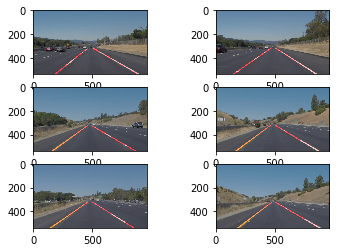

In [6]:
# Try out the function process_image
for i in range(len(image_list)):
    plt.subplot(3,2,i+1)
    init = 1
    plt.imshow(process_image(image_list[i]))

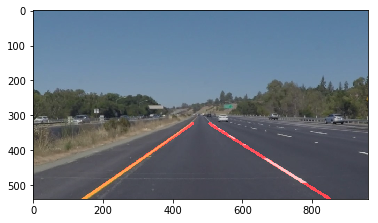

In [19]:
# Sample image
init = 1
plt.imshow(process_image(image_list[4]))

In [8]:
img = image_list[4]
mpimg.imsave('sample_images/ini_img.jpg', img)

In [9]:
img_lane = color_extract(img)
mpimg.imsave('sample_images/img_lane.jpg', img_lane)

In [11]:
img_gray = grayscale(img_lane)
mpimg.imsave('sample_images/img_gray.jpg', img_gray, cmap='gray')

In [12]:
img_blur = gaussian_blur(img_gray, kernel_size=7)
mpimg.imsave('sample_images/img_blur.jpg', img_blur, cmap='gray')

In [13]:
img_canny = canny(img_blur, canny_low_threshold, high_threshold=150)
mpimg.imsave('sample_images/img_canny.jpg', img_canny, cmap='gray')

In [17]:
init = 1
img_masked = img_mask(img_canny,region_bottom, region_top, region_height)
mpimg.imsave('sample_images/img_masked.jpg', img_masked, cmap='gray')

In [18]:
init = 1
img_hough = hough_lines(img_masked, hough_rho, hough_theta, hough_threshold, hough_min_line_length, hough_max_line_gap)
mpimg.imsave('sample_images/img_hough.jpg', img_hough)

In [16]:
img_weighted = weighted_img(img_hough, img)
mpimg.imsave('sample_images/img_weighted.jpg', img_weighted)

In [20]:
init = 1
img_weighted = process_image(img)
mpimg.imsave('sample_images/img_weighted.jpg', img_weighted)